# Whatami

I am a simple experiment on using qlearning agent setup for MountainCar problem.
Being off-policy value based algorithm, qlearning has comparatively poor convergence on this problem (see a2c nearby for comparison) yet it does manage to find some policy that brings him to the end.


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


In [1]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game and check that it works

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


env: THEANO_FLAGS="floatX=float32"


In [3]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
obs = env.step(0)[0]
action_names = np.array(["left",'stop',"right"]) #i guess so... i may be wrong
state_size = len(obs)
print(obs)

[2016-11-28 01:22:35,789] Making new env: MountainCar-v0


[-0.5693506  -0.00066286]


# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using shallow neural network.


In [5]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,batch_norm,dropout
#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


Couldn't import dot_parser, loading of dot files will not be possible.


In [6]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.05))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [7]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              action_layers=action_layer)


In [8]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [9]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


[2016-11-28 01:22:36,589] Making new env: MountainCar-v0


In [10]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'right' 'right' 'right' 'right' 'right' 'left']]
[[-1. -1. -1. -1. -1. -1.  0.]]
CPU times: user 7.81 ms, sys: 31.7 ms, total: 39.5 ms
Wall time: 17.7 ms


In [11]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [12]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [13]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [14]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.01)

In [15]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [16]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

[2016-11-28 01:22:42,680] Making new env: MountainCar-v0
[2016-11-28 01:22:42,683] Clearing 3 monitor files from previous run (because force=True was provided)
[2016-11-28 01:22:42,760] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')


Episode finished after 200 timesteps with reward=-200.0


In [17]:
from IPython.display import HTML

#video_path="./records/openaigym.video.0.7346.video000000.mp4"

#HTML("""
#<video width="640" height="480" controls>
#  <source src="{}" type="video/mp4">
#</video>
#""".format(video_path))


# Training loop

In [18]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [19]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,)


100%|██████████| 1000/1000 [00:03<00:00, 254.12it/s]


In [20]:

#the loop may take eons to finish.
#consider interrupting early.
for i in tqdm(range(10000)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,)
    for i in range(10):
        loss = train_step()
        
    
    
    if epoch_counter%100==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i"%(epoch_counter,
                                                         action_layer.epsilon.get_value(),
                                                         pool_mean_reward,
                                                         pool_size))
        

    ##record current learning progress and show learning curves
    if epoch_counter%500 ==0:
        n_games = 10
        action_layer.epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        action_layer.epsilon.set_value(0.05)
    
    
    epoch_counter  +=1

    
# Time to drink some coffee!

  1%|          | 100/10000 [00:26<1:00:37,  2.72it/s]

iter=100	epsilon=0.050	reward/step=-0.99994	pool_size=2001


  2%|▏         | 200/10000 [01:04<51:11,  3.19it/s]

iter=200	epsilon=0.050	reward/step=-0.99980	pool_size=3001


  3%|▎         | 300/10000 [01:27<36:27,  4.43it/s]

iter=300	epsilon=0.050	reward/step=-0.99935	pool_size=4001


  4%|▍         | 400/10000 [01:49<34:10,  4.68it/s]

iter=400	epsilon=0.050	reward/step=-0.99909	pool_size=5001


  5%|▍         | 499/10000 [02:11<35:31,  4.46it/s][2016-11-28 01:24:59,030] Making new env: MountainCar-v0
[2016-11-28 01:24:59,033] Clearing 2 monitor files from previous run (because force=True was provided)


iter=500	epsilon=0.050	reward/step=-0.99888	pool_size=6001


[2016-11-28 01:24:59,607] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
  5%|▌         | 500/10000 [02:12<1:02:11,  2.55it/s]

Current score(mean over 10) = -130.000


  6%|▌         | 600/10000 [02:35<34:07,  4.59it/s]

iter=600	epsilon=0.050	reward/step=-0.99865	pool_size=7001


  7%|▋         | 700/10000 [02:57<32:29,  4.77it/s]

iter=700	epsilon=0.050	reward/step=-0.99848	pool_size=8001


  8%|▊         | 800/10000 [03:19<32:04,  4.78it/s]

iter=800	epsilon=0.050	reward/step=-0.99830	pool_size=9001


  9%|▉         | 901/10000 [03:40<29:06,  5.21it/s]

iter=900	epsilon=0.050	reward/step=-0.99816	pool_size=10000


 10%|▉         | 999/10000 [04:00<34:53,  4.30it/s][2016-11-28 01:26:47,986] Making new env: MountainCar-v0
[2016-11-28 01:26:47,989] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1000	epsilon=0.050	reward/step=-0.99786	pool_size=10000


[2016-11-28 01:26:48,522] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 10%|█         | 1001/10000 [04:01<52:44,  2.84it/s]  

Current score(mean over 10) = -134.400


 11%|█         | 1100/10000 [04:24<31:49,  4.66it/s]

iter=1100	epsilon=0.050	reward/step=-0.99757	pool_size=10000


 12%|█▏        | 1201/10000 [04:48<31:32,  4.65it/s]

iter=1200	epsilon=0.050	reward/step=-0.99727	pool_size=10000


 13%|█▎        | 1301/10000 [05:08<27:51,  5.20it/s]

iter=1300	epsilon=0.050	reward/step=-0.99711	pool_size=10000


 14%|█▍        | 1400/10000 [05:29<34:56,  4.10it/s]

iter=1400	epsilon=0.050	reward/step=-0.99696	pool_size=10000


 15%|█▍        | 1499/10000 [05:50<31:23,  4.51it/s][2016-11-28 01:28:37,308] Making new env: MountainCar-v0
[2016-11-28 01:28:37,312] Clearing 2 monitor files from previous run (because force=True was provided)


iter=1500	epsilon=0.050	reward/step=-0.99680	pool_size=10000


[2016-11-28 01:28:37,775] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 15%|█▌        | 1500/10000 [05:50<51:19,  2.76it/s]

Current score(mean over 10) = -107.500


 16%|█▌        | 1600/10000 [06:11<31:32,  4.44it/s]

iter=1600	epsilon=0.050	reward/step=-0.99671	pool_size=10000


 17%|█▋        | 1700/10000 [06:40<45:40,  3.03it/s]

iter=1700	epsilon=0.050	reward/step=-0.99659	pool_size=10000


 18%|█▊        | 1800/10000 [07:12<38:45,  3.53it/s]

iter=1800	epsilon=0.050	reward/step=-0.99654	pool_size=10000


 19%|█▉        | 1900/10000 [07:45<49:13,  2.74it/s]

iter=1900	epsilon=0.050	reward/step=-0.99649	pool_size=10000


 20%|█▉        | 1999/10000 [08:14<39:04,  3.41it/s][2016-11-28 01:31:02,171] Making new env: MountainCar-v0
[2016-11-28 01:31:02,174] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2000	epsilon=0.050	reward/step=-0.99645	pool_size=10000


[2016-11-28 01:31:02,868] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 20%|██        | 2000/10000 [08:15<1:09:05,  1.93it/s]

Current score(mean over 10) = -162.600


 21%|██        | 2100/10000 [08:47<52:01,  2.53it/s]

iter=2100	epsilon=0.050	reward/step=-0.99643	pool_size=10000


 22%|██▏       | 2200/10000 [09:14<25:11,  5.16it/s]

iter=2200	epsilon=0.050	reward/step=-0.99645	pool_size=10000


 23%|██▎       | 2300/10000 [09:34<26:04,  4.92it/s]

iter=2300	epsilon=0.050	reward/step=-0.99647	pool_size=10000


 24%|██▍       | 2401/10000 [09:55<24:13,  5.23it/s]

iter=2400	epsilon=0.050	reward/step=-0.99649	pool_size=10000


 25%|██▍       | 2499/10000 [10:15<26:48,  4.66it/s][2016-11-28 01:33:02,298] Making new env: MountainCar-v0
[2016-11-28 01:33:02,301] Clearing 2 monitor files from previous run (because force=True was provided)


iter=2500	epsilon=0.050	reward/step=-0.99653	pool_size=10000


[2016-11-28 01:33:02,768] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 25%|██▌       | 2500/10000 [10:15<44:11,  2.83it/s]

Current score(mean over 10) = -121.800


 26%|██▌       | 2601/10000 [10:36<23:59,  5.14it/s]

iter=2600	epsilon=0.050	reward/step=-0.99657	pool_size=10000


 27%|██▋       | 2700/10000 [10:58<26:32,  4.58it/s]

iter=2700	epsilon=0.050	reward/step=-0.99663	pool_size=10000


 28%|██▊       | 2801/10000 [11:19<24:36,  4.88it/s]

iter=2800	epsilon=0.050	reward/step=-0.99666	pool_size=10000


 29%|██▉       | 2901/10000 [11:40<22:09,  5.34it/s]

iter=2900	epsilon=0.050	reward/step=-0.99668	pool_size=10000


 30%|██▉       | 2999/10000 [12:00<24:11,  4.82it/s][2016-11-28 01:34:47,929] Making new env: MountainCar-v0
[2016-11-28 01:34:47,931] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3000	epsilon=0.050	reward/step=-0.99668	pool_size=10000


[2016-11-28 01:34:48,381] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 30%|███       | 3000/10000 [12:01<42:19,  2.76it/s]

Current score(mean over 10) = -124.100


 31%|███       | 3100/10000 [12:22<25:55,  4.44it/s]

iter=3100	epsilon=0.050	reward/step=-0.99664	pool_size=10000


 32%|███▏      | 3201/10000 [12:44<22:33,  5.02it/s]

iter=3200	epsilon=0.050	reward/step=-0.99664	pool_size=10000


 33%|███▎      | 3301/10000 [13:04<21:38,  5.16it/s]

iter=3300	epsilon=0.050	reward/step=-0.99666	pool_size=10000


 34%|███▍      | 3401/10000 [13:25<21:30,  5.11it/s]

iter=3400	epsilon=0.050	reward/step=-0.99666	pool_size=10000


 35%|███▍      | 3499/10000 [13:46<22:45,  4.76it/s][2016-11-28 01:36:33,832] Making new env: MountainCar-v0
[2016-11-28 01:36:33,835] Clearing 2 monitor files from previous run (because force=True was provided)


iter=3500	epsilon=0.050	reward/step=-0.99666	pool_size=10000


[2016-11-28 01:36:34,314] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 35%|███▌      | 3500/10000 [13:47<38:39,  2.80it/s]

Current score(mean over 10) = -126.000


 36%|███▌      | 3600/10000 [14:10<22:12,  4.80it/s]

iter=3600	epsilon=0.050	reward/step=-0.99669	pool_size=10000


 37%|███▋      | 3700/10000 [14:32<25:20,  4.14it/s]

iter=3700	epsilon=0.050	reward/step=-0.99670	pool_size=10000


 38%|███▊      | 3800/10000 [14:54<23:51,  4.33it/s]

iter=3800	epsilon=0.050	reward/step=-0.99668	pool_size=10000


 39%|███▉      | 3900/10000 [15:16<21:07,  4.81it/s]

iter=3900	epsilon=0.050	reward/step=-0.99669	pool_size=10000


 40%|███▉      | 3999/10000 [15:38<25:30,  3.92it/s][2016-11-28 01:38:26,087] Making new env: MountainCar-v0
[2016-11-28 01:38:26,090] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4000	epsilon=0.050	reward/step=-0.99674	pool_size=10000


[2016-11-28 01:38:26,664] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 40%|████      | 4001/10000 [15:39<35:29,  2.82it/s]

Current score(mean over 10) = -153.700


 41%|████      | 4100/10000 [16:00<22:13,  4.42it/s]

iter=4100	epsilon=0.050	reward/step=-0.99682	pool_size=10000


 42%|████▏     | 4200/10000 [16:21<20:06,  4.81it/s]

iter=4200	epsilon=0.050	reward/step=-0.99685	pool_size=10000


 43%|████▎     | 4300/10000 [16:43<21:43,  4.37it/s]

iter=4300	epsilon=0.050	reward/step=-0.99688	pool_size=10000


 44%|████▍     | 4400/10000 [17:05<20:24,  4.57it/s]

iter=4400	epsilon=0.050	reward/step=-0.99692	pool_size=10000


 45%|████▍     | 4499/10000 [17:29<26:10,  3.50it/s][2016-11-28 01:40:16,564] Making new env: MountainCar-v0
[2016-11-28 01:40:16,567] Clearing 2 monitor files from previous run (because force=True was provided)


iter=4500	epsilon=0.050	reward/step=-0.99697	pool_size=10000


[2016-11-28 01:40:17,177] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 45%|████▌     | 4500/10000 [17:30<41:43,  2.20it/s]

Current score(mean over 10) = -154.800


 46%|████▌     | 4600/10000 [17:54<21:20,  4.22it/s]

iter=4600	epsilon=0.050	reward/step=-0.99697	pool_size=10000


 47%|████▋     | 4700/10000 [18:17<20:50,  4.24it/s]

iter=4700	epsilon=0.050	reward/step=-0.99700	pool_size=10000


 48%|████▊     | 4800/10000 [18:40<18:29,  4.69it/s]

iter=4800	epsilon=0.050	reward/step=-0.99702	pool_size=10000


 49%|████▉     | 4900/10000 [19:03<22:02,  3.86it/s]

iter=4900	epsilon=0.050	reward/step=-0.99705	pool_size=10000


 50%|████▉     | 4999/10000 [19:27<18:19,  4.55it/s][2016-11-28 01:42:14,252] Making new env: MountainCar-v0
[2016-11-28 01:42:14,256] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5000	epsilon=0.050	reward/step=-0.99707	pool_size=10000


[2016-11-28 01:42:15,107] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 50%|█████     | 5000/10000 [19:28<40:06,  2.08it/s]

Current score(mean over 10) = -200.000


 51%|█████     | 5100/10000 [19:50<17:11,  4.75it/s]

iter=5100	epsilon=0.050	reward/step=-0.99707	pool_size=10000


 52%|█████▏    | 5200/10000 [20:10<15:15,  5.24it/s]

iter=5200	epsilon=0.050	reward/step=-0.99711	pool_size=10000


 53%|█████▎    | 5301/10000 [20:32<21:05,  3.71it/s]

iter=5300	epsilon=0.050	reward/step=-0.99712	pool_size=10000


 54%|█████▍    | 5401/10000 [20:52<14:40,  5.22it/s]

iter=5400	epsilon=0.050	reward/step=-0.99711	pool_size=10000


 55%|█████▍    | 5499/10000 [21:12<14:38,  5.12it/s][2016-11-28 01:43:59,827] Making new env: MountainCar-v0
[2016-11-28 01:43:59,830] Clearing 2 monitor files from previous run (because force=True was provided)


iter=5500	epsilon=0.050	reward/step=-0.99709	pool_size=10000


[2016-11-28 01:44:00,452] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 55%|█████▌    | 5500/10000 [21:13<28:44,  2.61it/s]

Current score(mean over 10) = -163.000


 56%|█████▌    | 5601/10000 [21:36<14:38,  5.01it/s]

iter=5600	epsilon=0.050	reward/step=-0.99707	pool_size=10000


 57%|█████▋    | 5700/10000 [21:57<14:57,  4.79it/s]

iter=5700	epsilon=0.050	reward/step=-0.99709	pool_size=10000


 58%|█████▊    | 5801/10000 [22:19<16:29,  4.24it/s]

iter=5800	epsilon=0.050	reward/step=-0.99712	pool_size=10000


 59%|█████▉    | 5901/10000 [22:40<14:08,  4.83it/s]

iter=5900	epsilon=0.050	reward/step=-0.99714	pool_size=10000


 60%|█████▉    | 5999/10000 [23:01<15:24,  4.33it/s][2016-11-28 01:45:48,193] Making new env: MountainCar-v0
[2016-11-28 01:45:48,196] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6000	epsilon=0.050	reward/step=-0.99711	pool_size=10000


[2016-11-28 01:45:48,767] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 60%|██████    | 6000/10000 [23:01<26:18,  2.53it/s]

Current score(mean over 10) = -129.700


 61%|██████    | 6100/10000 [23:25<16:10,  4.02it/s]

iter=6100	epsilon=0.050	reward/step=-0.99706	pool_size=10000


 62%|██████▏   | 6200/10000 [23:46<12:58,  4.88it/s]

iter=6200	epsilon=0.050	reward/step=-0.99697	pool_size=10000


 63%|██████▎   | 6301/10000 [24:07<12:30,  4.93it/s]

iter=6300	epsilon=0.050	reward/step=-0.99687	pool_size=10000


 64%|██████▍   | 6401/10000 [24:28<11:48,  5.08it/s]

iter=6400	epsilon=0.050	reward/step=-0.99683	pool_size=10000


 65%|██████▍   | 6499/10000 [24:49<13:19,  4.38it/s][2016-11-28 01:47:36,500] Making new env: MountainCar-v0
[2016-11-28 01:47:36,504] Clearing 2 monitor files from previous run (because force=True was provided)


iter=6500	epsilon=0.050	reward/step=-0.99685	pool_size=10000


[2016-11-28 01:47:36,949] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 65%|██████▌   | 6500/10000 [24:50<22:11,  2.63it/s]

Current score(mean over 10) = -113.500


 66%|██████▌   | 6601/10000 [25:11<10:45,  5.26it/s]

iter=6600	epsilon=0.050	reward/step=-0.99685	pool_size=10000


 67%|██████▋   | 6700/10000 [25:32<12:43,  4.32it/s]

iter=6700	epsilon=0.050	reward/step=-0.99678	pool_size=10000


 68%|██████▊   | 6800/10000 [25:54<11:37,  4.59it/s]

iter=6800	epsilon=0.050	reward/step=-0.99673	pool_size=10000


 69%|██████▉   | 6900/10000 [26:16<10:18,  5.01it/s]

iter=6900	epsilon=0.050	reward/step=-0.99668	pool_size=10000


 70%|██████▉   | 6999/10000 [26:39<12:57,  3.86it/s][2016-11-28 01:49:26,442] Making new env: MountainCar-v0
[2016-11-28 01:49:26,456] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7000	epsilon=0.050	reward/step=-0.99666	pool_size=10000


[2016-11-28 01:49:27,272] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 70%|███████   | 7000/10000 [26:40<25:22,  1.97it/s]

Current score(mean over 10) = -190.300


 71%|███████   | 7100/10000 [27:02<11:28,  4.21it/s]

iter=7100	epsilon=0.050	reward/step=-0.99667	pool_size=10000


 72%|███████▏  | 7201/10000 [27:25<10:30,  4.44it/s]

iter=7200	epsilon=0.050	reward/step=-0.99676	pool_size=10000


 73%|███████▎  | 7301/10000 [27:47<09:52,  4.55it/s]

iter=7300	epsilon=0.050	reward/step=-0.99685	pool_size=10000


 74%|███████▍  | 7401/10000 [28:08<08:26,  5.14it/s]

iter=7400	epsilon=0.050	reward/step=-0.99688	pool_size=10000


 75%|███████▍  | 7499/10000 [28:29<08:24,  4.95it/s][2016-11-28 01:51:17,198] Making new env: MountainCar-v0
[2016-11-28 01:51:17,201] Clearing 2 monitor files from previous run (because force=True was provided)


iter=7500	epsilon=0.050	reward/step=-0.99688	pool_size=10000


[2016-11-28 01:51:17,664] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 75%|███████▌  | 7500/10000 [28:30<15:04,  2.76it/s]

Current score(mean over 10) = -119.400


 76%|███████▌  | 7601/10000 [28:54<08:40,  4.61it/s]

iter=7600	epsilon=0.050	reward/step=-0.99690	pool_size=10000


 77%|███████▋  | 7700/10000 [29:15<08:09,  4.70it/s]

iter=7700	epsilon=0.050	reward/step=-0.99695	pool_size=10000


 78%|███████▊  | 7800/10000 [29:38<07:37,  4.81it/s]

iter=7800	epsilon=0.050	reward/step=-0.99699	pool_size=10000


 79%|███████▉  | 7901/10000 [29:59<07:30,  4.66it/s]

iter=7900	epsilon=0.050	reward/step=-0.99703	pool_size=10000


 80%|███████▉  | 7999/10000 [30:20<07:56,  4.20it/s][2016-11-28 01:53:07,570] Making new env: MountainCar-v0
[2016-11-28 01:53:07,573] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8000	epsilon=0.050	reward/step=-0.99711	pool_size=10000


[2016-11-28 01:53:08,338] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 80%|████████  | 8001/10000 [30:21<12:23,  2.69it/s]

Current score(mean over 10) = -200.000


 81%|████████  | 8100/10000 [30:43<06:40,  4.74it/s]

iter=8100	epsilon=0.050	reward/step=-0.99716	pool_size=10000


 82%|████████▏ | 8200/10000 [31:04<06:04,  4.94it/s]

iter=8200	epsilon=0.050	reward/step=-0.99718	pool_size=10000


 83%|████████▎ | 8300/10000 [31:27<06:59,  4.05it/s]

iter=8300	epsilon=0.050	reward/step=-0.99718	pool_size=10000


 84%|████████▍ | 8400/10000 [31:51<05:53,  4.52it/s]

iter=8400	epsilon=0.050	reward/step=-0.99723	pool_size=10000


 85%|████████▍ | 8499/10000 [32:13<05:29,  4.56it/s][2016-11-28 01:55:00,633] Making new env: MountainCar-v0
[2016-11-28 01:55:00,635] Clearing 2 monitor files from previous run (because force=True was provided)


iter=8500	epsilon=0.050	reward/step=-0.99725	pool_size=10000


[2016-11-28 01:55:01,376] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 85%|████████▌ | 8500/10000 [32:14<10:57,  2.28it/s]

Current score(mean over 10) = -185.300


 86%|████████▌ | 8601/10000 [32:35<04:39,  5.01it/s]

iter=8600	epsilon=0.050	reward/step=-0.99726	pool_size=10000


 87%|████████▋ | 8701/10000 [32:55<04:11,  5.17it/s]

iter=8700	epsilon=0.050	reward/step=-0.99726	pool_size=10000


 88%|████████▊ | 8801/10000 [33:16<04:07,  4.84it/s]

iter=8800	epsilon=0.050	reward/step=-0.99728	pool_size=10000


 89%|████████▉ | 8900/10000 [33:36<04:36,  3.97it/s]

iter=8900	epsilon=0.050	reward/step=-0.99727	pool_size=10000


 90%|████████▉ | 8999/10000 [33:56<03:27,  4.83it/s][2016-11-28 01:56:43,446] Making new env: MountainCar-v0
[2016-11-28 01:56:43,450] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9000	epsilon=0.050	reward/step=-0.99721	pool_size=10000


[2016-11-28 01:56:43,926] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 90%|█████████ | 9001/10000 [33:57<04:54,  3.39it/s]

Current score(mean over 10) = -116.700


 91%|█████████ | 9101/10000 [34:17<02:46,  5.38it/s]

iter=9100	epsilon=0.050	reward/step=-0.99718	pool_size=10000


 92%|█████████▏| 9200/10000 [34:38<03:02,  4.39it/s]

iter=9200	epsilon=0.050	reward/step=-0.99718	pool_size=10000


 93%|█████████▎| 9300/10000 [34:58<02:15,  5.16it/s]

iter=9300	epsilon=0.050	reward/step=-0.99716	pool_size=10000


 94%|█████████▍| 9401/10000 [35:18<02:00,  4.98it/s]

iter=9400	epsilon=0.050	reward/step=-0.99714	pool_size=10000


 95%|█████████▍| 9499/10000 [35:39<01:48,  4.63it/s][2016-11-28 01:58:26,504] Making new env: MountainCar-v0
[2016-11-28 01:58:26,507] Clearing 2 monitor files from previous run (because force=True was provided)


iter=9500	epsilon=0.050	reward/step=-0.99714	pool_size=10000


[2016-11-28 01:58:26,958] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
 95%|█████████▌| 9501/10000 [35:40<02:29,  3.34it/s]

Current score(mean over 10) = -122.000


 96%|█████████▌| 9600/10000 [36:00<01:29,  4.49it/s]

iter=9600	epsilon=0.050	reward/step=-0.99713	pool_size=10000


 97%|█████████▋| 9701/10000 [36:20<00:55,  5.36it/s]

iter=9700	epsilon=0.050	reward/step=-0.99712	pool_size=10000


 98%|█████████▊| 9800/10000 [36:41<00:42,  4.69it/s]

iter=9800	epsilon=0.050	reward/step=-0.99707	pool_size=10000


 99%|█████████▉| 9901/10000 [37:02<00:19,  5.08it/s]

iter=9900	epsilon=0.050	reward/step=-0.99707	pool_size=10000


100%|█████████▉| 9999/10000 [37:26<00:00,  3.64it/s][2016-11-28 02:00:13,921] Making new env: MountainCar-v0
[2016-11-28 02:00:13,926] Clearing 2 monitor files from previous run (because force=True was provided)


iter=10000	epsilon=0.050	reward/step=-0.99710	pool_size=10000


[2016-11-28 02:00:14,664] Finished writing results. You can upload them to the scoreboard via gym.upload('/root/drqn/records')
100%|██████████| 10000/10000 [37:27<00:00,  1.99it/s]

Current score(mean over 10) = -178.700


In [26]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))

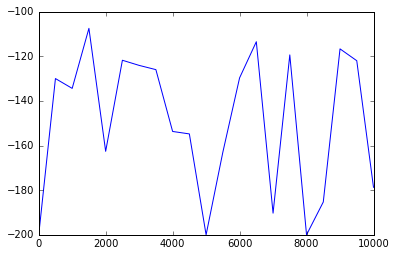

In [27]:
plt.plot(iters,map(np.mean,session_rewards))